## Downloading the dataset

Here we are going to use [this](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) kaggle dataset.

In [ ]:
import gdown
import shutil
import os
url = "https://drive.google.com/uc?export=download&id=19wXSTiciy8D3URGGpvn55UZQgKypTIT4"
output = os.path.join(os.getcwd(),'Data','dataset.zip')
gdown.cached_download(url, output, postprocess=gdown.extractall)
os.remove(output)

if os.path.exists('sample_data'):
    shutil.rmtree('sample_data')

Cached Downloading: /content/Data/dataset.zip
Downloading...
From: https://drive.google.com/uc?export=download&id=19wXSTiciy8D3URGGpvn55UZQgKypTIT4
To: /root/.cache/gdown/tmpjm03j6g_/dl
100%|██████████| 213M/213M [00:04<00:00, 43.1MB/s]


In [ ]:
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

WORKING_DIR = os.getcwd()
ANN_PATH = os.path.join(WORKING_DIR,"Data","annotations")
IMG_PATH = os.path.join(WORKING_DIR,"Data","images")
YOLO_DATASET_PATH = os.path.join(WORKING_DIR,"Yolo_dataset")

## Converting the dataset to YOLO format

The dataset is in Pascal Voc format. So before train our YOLO model we have to convert the dataset to YOLO format.

In [ ]:
def save_image_and_label(yolo_dataset_path, img, ann_lines, img_name_portion, split):
    """
    This function will create split, images and labels folders then it 
    will save image and annotation file in the corresponding folder

    - param yolo_dataset_path(String): The folder where yolo dataset need to be saved
    - param img(numpy array): The resized image in BGR format
    - param ann_lines(String list): annotation lines for each object 
    ['cls xmid ymid w h conf',
     'cls xmid ymid w h conf']
    - param img_name_portion(String) : Name of the image without extension
    - split(String): "train" , "valid" or test
    - return : None
    """ 
    folder = os.path.join(yolo_dataset_path, split) 
    img_folder = os.path.join(folder, 'images')
    label_folder = os.path.join(folder, 'labels')
    if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(img_folder)
            os.makedirs(label_folder)
    out_img_path = os.path.join(img_folder, img_name_portion+'.jpg')
    out_ann_path = os.path.join(label_folder, img_name_portion+'.txt')
    cv2.imwrite(out_img_path, img)
    text_file = open(out_ann_path, "w")
    for ann_line in ann_lines:
        text_file.write(ann_line+'\n')
    text_file.close()
    return None

def create_yolo_dataset(img_path, ann_path, yolo_dataset_path, testing_size, valid_size):
    """
    This function will create a yolo dataset
    This function only will work for single object per image
    - param img_path(String): The image folder where Pascal Voc dataset exist
    - param ann_path(String): The label folder where Pascal Voc dataset exist
    - param yolo_dataset_path(String): The folder where yolo dataset need to be saved
    - param testing_size(int) : Number of testing samples
    - param valid_size(int) : Number of testing samples
    - return : yolo dataset path
    """

    img_list = os.listdir(img_path)
    print("Total samples: ",len(img_list))
    np.random.shuffle(img_list)
    test_i = testing_size
    valid_i = testing_size + valid_size

    for i, img_name in enumerate(img_list):
        img_file_path = os.path.join(img_path,img_name)
        img_name_portion, extension = os.path.splitext(img_name)
        ann_file_name = img_name_portion +'.xml'
        ann_file_path = os.path.join(ann_path,ann_file_name)
        root = xet.parse(ann_file_path).getroot()
        member_object=root.find('object')
        labels_info=member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)
        bh = ymax - ymin
        bw = xmax - xmin
        img = cv2.imread(img_file_path)
        h,w,_ = img.shape
        img = cv2.resize(img,(640,640))
        ann_line = '0 '+str((xmin+bw/2)/w)+' '+str((ymin+bh/2)/h)+' '+str(bw/w)+' '+str(bh/h)

        if i<test_i:
            save_image_and_label(yolo_dataset_path, img,[ann_line], img_name_portion, 'test')
        elif i<valid_i:
            save_image_and_label(yolo_dataset_path, img,[ann_line], img_name_portion, 'valid')
        else:
            save_image_and_label(yolo_dataset_path, img,[ann_line], img_name_portion, 'train')

    return yolo_dataset_path

if os.path.exists(YOLO_DATASET_PATH):
    shutil.rmtree(YOLO_DATASET_PATH)
create_yolo_dataset(IMG_PATH, ANN_PATH, YOLO_DATASET_PATH, 50, 100)

Total samples:  433


'/content/Yolo_dataset'

### This the dataset configuration file 

In [ ]:
%%writefile '/content/Yolo_dataset/data.yaml'
train: /content/Yolo_dataset/train/images
val: /content/Yolo_dataset/valid/images

nc: 1
names: ['Licence plate']

Writing /content/Yolo_dataset/data.yaml


## Testing the YOLO format

To verify our dataset labels let's plot some images.

In [ ]:
def select_random_imgs(dataset_path, split, num):
    img_data_folder = os.path.join(dataset_path,split,'images')
    ann_data_folder = os.path.join(dataset_path,split,'labels')
    img_list = os.listdir(img_data_folder)
    choices = random.choices(img_list, k=num)
    imgs, anns = [], []
    for choice in choices:
        img_file = os.path.join(img_data_folder,choice)
        rgb = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
        imgs.append(rgb)
        name_portion, ext = os.path.splitext(choice)
        ann_file = os.path.join(ann_data_folder, name_portion+'.txt')
        f = open(ann_file)
        Lines = f.readlines()

        img_ann = []
        for line in Lines:
            single_ann = np.array(line.replace('\n','').split(' '), dtype=float)
            img_ann.append(single_ann)
        anns.append(img_ann)
        
    return imgs, anns

In [ ]:
def plot_boxes(imgs, anns, classes):
    plotted_imgs = []
    for img, ann in zip(imgs, anns):
        plotted_img = img.copy()
        H, W, _ = img.shape
        for box in ann:
            if len(box)==6:
                cls, x, y, w, h, conf = box
                conf = " {:.2f}".format(conf)
            else:
                cls, x, y, w, h = box
                conf = ''
            cls, x, y, w, h = int(cls), int(x*W), int(y*H), int(w*W), int(h*H)
            xmin, ymin = int(x-w/2), int(y-h/2)
            xmax, ymax = xmin+w, ymin+h
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            txt_pos = (xmin, ymin-10)
            txt = classes[cls] + conf
            plotted_img=cv2.rectangle(plotted_img, pt1, pt2, [255,0,0], 2)
            cv2.putText(plotted_img,classes[cls], txt_pos,cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255,0,0], 2)
        
        plotted_imgs.append(plotted_img)
    
    return plotted_imgs

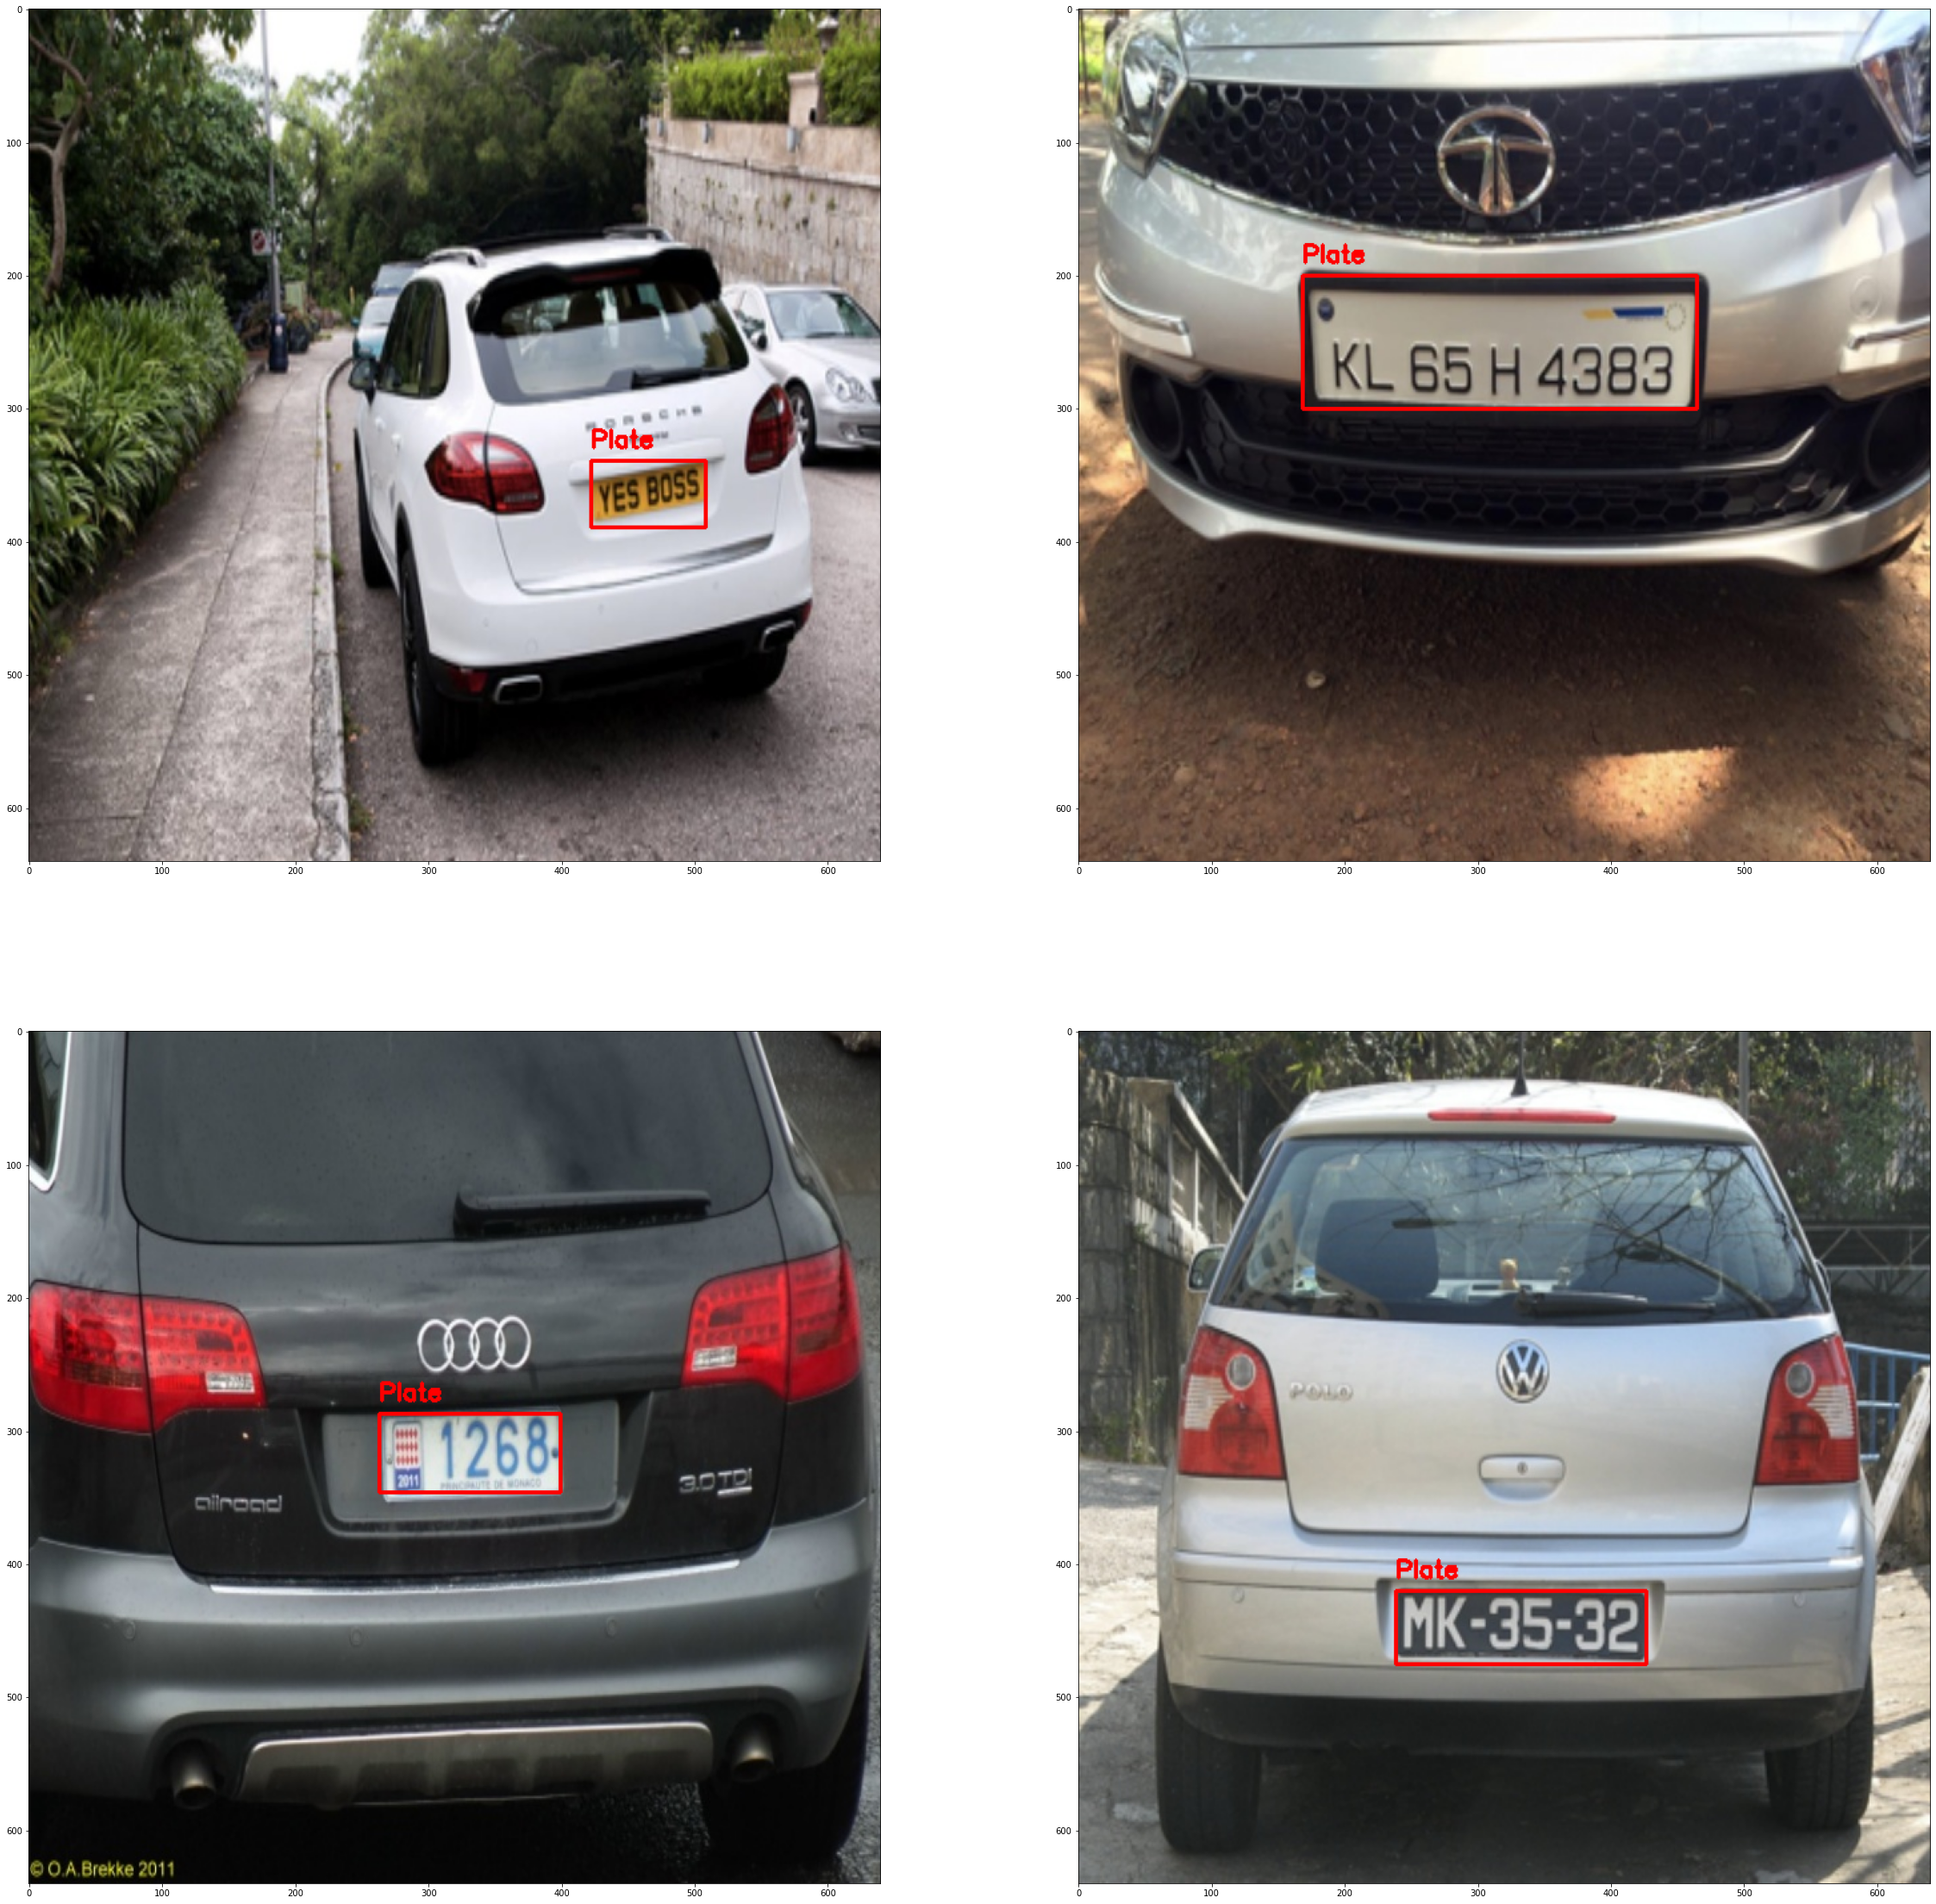

In [ ]:
imgs, anns = select_random_imgs('/content/Yolo_dataset', 'train', 4)
plotted_imgs = plot_boxes(imgs, anns, ['Plate'])
plt.rcParams["figure.figsize"] = (40,40)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(plotted_imgs[0])
axarr[0,1].imshow(plotted_imgs[1])
axarr[1,0].imshow(plotted_imgs[2])
axarr[1,1].imshow(plotted_imgs[3])

## YOLO V5 Model

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git  # clone
%cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12310, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12310 (delta 16), reused 17 (delta 13), pack-reused 12287
Receiving objects: 100% (12310/12310), 12.63 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (8484/8484), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 40.6 MB/s 


### Training YOLO V5

In [ ]:
!python train.py --img 640 --batch 10 --epochs 80 --data /content/Yolo_dataset/data.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=/content/Yolo_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=80, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-110-ga4ed988 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hs

In [ ]:
#to download the zip file of dataset which is according to the yolo
!zip -r /content/Yolo_dataset.zip /content/Yolo_dataset

In [ ]:
## to download the whole model and data dataset in our local system
!zip -r /content/yolov5-4.zip /content/yolov5

## Predict with torch hub

In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', '/content/yolov5/runs/train/exp/weights/best.pt')  

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-15 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15

In [ ]:
import cv2

In [ ]:
im = cv2.imread('/content/india-skoda-license-plate.jpg')
results = model(im)
pred_img = results.imgs
df = results.pandas().xyxy[0]
df.to_numpy()

AttributeError: ignored